In [1]:
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import blackjax

from rhmcjax.targets.gaussians_on_circle import GaussiansOnCircle

### Standard Hamiltonian Monte Carlo (HMC) with [`blackjax`](https://blackjax-devs.github.io/blackjax/index.html)
The following code is inspired by parts of the [`blackjax` tutorial](https://blackjax-devs.github.io/blackjax/examples/quickstart.html). Oftentimes, the goal of HMC is to infer the unknown parameters of some target distribution based on samples from this target. However, this is different in physics where the target distribution is analytically available: To estimate properties of the physics target (e.g. some expectation value), a vast amount of samples have to be drawn. HMC can be utilized for this purpose as well, without the usual inference step.
In this notebook, we will illustrate how to use `blackjax.hmc` to obtain samples and show that these samples are reproduce the target distribution. 

In general, MCMC algorithms assume that the distribution is defined on an unconstrained Euclidean space. An example would be a Gaussian distribution. We will use a slightly more complex (and more interesting) target which consists of multiple Gaussians on a circle. The distribution $p(x)$ and its log-density $log p(x)$ are visualized in the following.

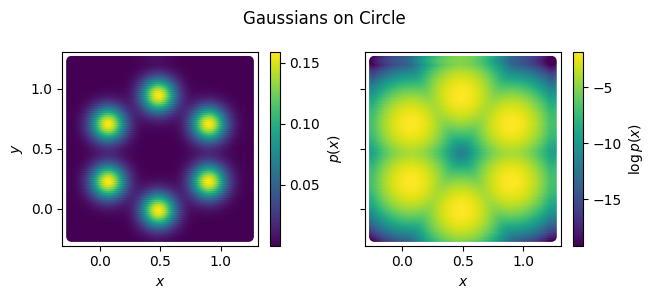

In [2]:
key = jax.random.key(seed=42)

unconstrained_target = GaussiansOnCircle(restrict_to_unit_hypercube=False)
x = jnp.linspace(-0.25, 1.25, 100)[1:-1]
grid_unit = jnp.dstack(jnp.meshgrid(x, x))
grid_unit = grid_unit.reshape([-1, 2])
p_vals = unconstrained_target.prob(grid_unit)

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(7,3))
colorbar = axes[0].scatter(grid_unit[:,0], grid_unit[:,1], c=p_vals)
cbar = fig.colorbar(colorbar, ax=axes[0])
cbar.set_label(r'$p(x)$')
axes[0].set_xlabel(r'$x$')
axes[0].set_ylabel(r'$y$')

logp_vals = unconstrained_target.log_prob(grid_unit)
colorbar = axes[1].scatter(grid_unit[:,0], grid_unit[:,1], c=logp_vals)
cbar = fig.colorbar(colorbar, ax=axes[1])
cbar.set_label(r'$\log p(x)$')
axes[1].set_xlabel(r'$x$')
fig.suptitle('Gaussians on Circle')

plt.tight_layout()

Since this distribution is unconstrained, we can use the standard HMC implementation of `blackjax`.

In [3]:
inv_mass_matrix = jnp.array([0.5, 0.01])
num_integration_steps = 60
step_size = 1e-3

logdensity = unconstrained_target.log_prob
hmc = blackjax.hmc(logdensity, step_size, inv_mass_matrix, num_integration_steps)

We have to specify an initial state for which we choose $x_0 = (0.2, 0.2)$.

In [4]:
initial_position = jnp.array([0.2, 0.2]).reshape([-1, 2])
initial_state = hmc.init(initial_position)
initial_state

HMCState(position=Array([[0.2, 0.2]], dtype=float32), logdensity=Array(-2.6819847, dtype=float32), logdensity_grad=Array([[-11.356661 ,   5.8773093]], dtype=float32))

Here, we can see that `blackjax` automatically evaluates the inital position `logdensity` and its gradient `logdensity_grad`. These values are used for initializing the HMC algorithm.

We define the function `one_step` that uses the HMC kernel to perform an update step. This function is called repeatedly with `jax.lax.scan` to run a full HMC chain in the function `hmc_run`. The positions of the intermediate states are returned and correspond to the samples of one HMC chain.

In [5]:
def run_hmc(key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, key):
        state, _ = kernel(key, state)
        return state, state

    keys = jax.random.split(key, num_samples)
    final_state, states = jax.lax.scan(one_step, initial_state, keys)

    return states.position

We run the HMC chain with 100,000 samples.

In [6]:
key, subkey = jax.random.split(key)
mcmc_samples = run_hmc(subkey, hmc.step, initial_state, 100_000)
mcmc_samples = mcmc_samples.squeeze()
mcmc_samples.shape

(100000, 2)

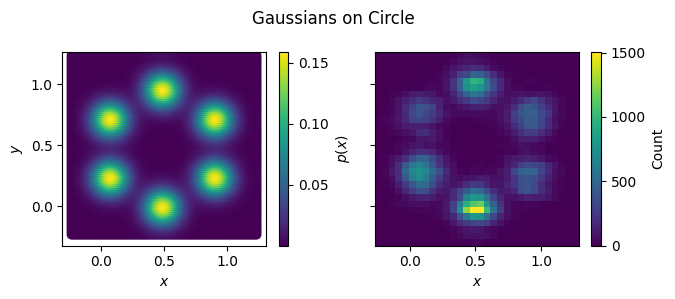

In [7]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(7,3))
colorbar = axes[0].scatter(grid_unit[:,0], grid_unit[:,1], c=p_vals)
cbar = fig.colorbar(colorbar, ax=axes[0])
cbar.set_label(r'$p(x)$')
axes[0].set_xlabel(r'$x$')
axes[0].set_ylabel(r'$y$')

h, x, y, img = axes[1].hist2d(mcmc_samples[:,0], mcmc_samples[:,1], bins=30)
cbar = fig.colorbar(img, ax=axes[1])
cbar.set_label('Count')
axes[1].set_xlabel(r'$x$')
fig.suptitle('Gaussians on Circle')

plt.tight_layout()

The results shows that all six peaks of the target where found, although modes further away from the initialization $(0.2,0.2)$ were explored less. Therefore, it is important to run multiple chains with different initializations. We choose 10 chains with 10,000 samples per chain.

In [8]:
key, subkey = jax.random.split(key)
initial_positions = jax.random.uniform(subkey, shape=[10, 2])
initial_positions.shape

(10, 2)

In [9]:
chains = []
for init_p in initial_positions:
    initial_position = init_p.reshape([-1, 2])
    key, subkey = jax.random.split(key)
    initial_state = hmc.init(initial_position)
    mcmc_samples = run_hmc(subkey, hmc.step, initial_state, 10_000)
    chains.append(mcmc_samples.squeeze())
mcmc_chains = jnp.array(chains)
mcmc_chains.shape

(10, 10000, 2)

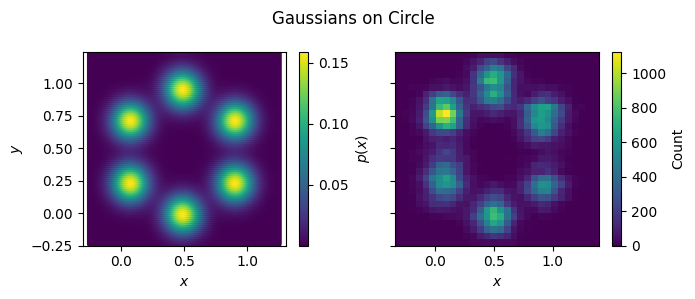

In [10]:
mcmc_chains = mcmc_chains.reshape([-1, 2])

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(7,3))
colorbar = axes[0].scatter(grid_unit[:,0], grid_unit[:,1], c=p_vals)
cbar = fig.colorbar(colorbar, ax=axes[0])
cbar.set_label(r'$p(x)$')
axes[0].set_xlabel(r'$x$')
axes[0].set_ylabel(r'$y$')

h, x, y, img = axes[1].hist2d(mcmc_chains[:,0], mcmc_chains[:,1], bins=30)
cbar = fig.colorbar(img, ax=axes[1])
cbar.set_label('Count')
axes[1].set_xlabel(r'$x$')
fig.suptitle('Gaussians on Circle')

plt.tight_layout()

Using 10 independent HMC chains results in a similar amount of samples from all six modes and shows better performance than one large HMC chain.